# Get metrics: heatwave, polluted day and wildfire

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import helper_400

%load_ext autoreload
%autoreload 2
helper_400.set_sns_style()


<Figure size 800x600 with 0 Axes>

In [2]:
df = pd.read_parquet("outputs/final_merge_5_western_us.parquet")

In [3]:
df = df.reset_index()

## Dates

In [4]:
df.time.min()

Timestamp('2006-01-01 00:00:00')

In [7]:
df.time.max() 

Timestamp('2020-12-31 00:00:00')

In [8]:
df = df.rename(columns={'location_label': 'GEOID'})

# Preprocessing

## Heat day - summer months over all time

In [55]:
def get_tmax95(x):
    summer_months = x[x['time'].dt.month.isin([6,7,8,9])]
    return summer_months['tmax'].quantile(0.95)  

tmax95_series = df.groupby('GEOID').apply(get_tmax95)

# To add this to the original df, you can merge or map the values
df['tmax95'] = df['GEOID'].map(tmax95_series)


In [64]:
extreme_day_threshold = 32.22 # in C

In [67]:
df['heatday'] = np.where(
    (df['tmax'] >= df['tmax95']) & (df['tmax']>= extreme_day_threshold), 
    True, 
    False)

In [68]:
dfc = df.groupby('GEOID')["tmax95"].first()

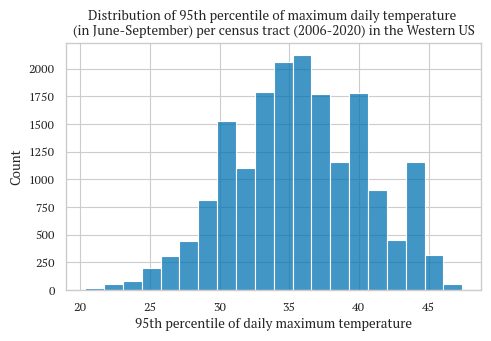

In [69]:
axs = plt.subplots(figsize=(5, 3.5))
axs = sns.histplot(dfc, bins=20)
axs.set_xlabel("95th percentile of daily maximum temperature")
axs.set_ylabel("Count")
axs.set_title("Distribution of 95th percentile of maximum daily temperature \n(in June-September) per census tract (2006-2020) in the Western US")
plt.tight_layout()
plt.savefig("figures/95th_percentile_distribution.png", dpi=300)

In [71]:
dfc[dfc < extreme_day_threshold].count()

4259

## Heat day rolling window of last 5 years

In [7]:
# df = df[df.FIPS.isin([1765.0,1766.0,1767.0])]

# df = df.head(30)

# df = df[['time','FIPS','tmax']]

We use the 95th percentile of the maximum daily temperatures as a treshold for identifying heat days. In particular, to count the heat days per each census tract, we first find the 95th percentile of the maximum daily temperature for the past 5 years for each date. For the first five years in our data, we just use the 95th percentile of the maximum temperature for that period. If a daily temperature exceeds the 95th percentile treshold for that date, the day is marked as a heat day.

In [16]:
def get_tmax95(x):
    # calculate rolling 95th percentile with a window size of 5 years (approx. 1825 days)
    rolling_95th = x.rolling(window=1825).quantile(0.95)
    
    # calculate 95th percentile for the first 5 years
    threshold = x[rolling_95th.isna()].quantile(0.95)
    # alternative: threshold = x[:window].quantile(0.95)
    rolling_95th = rolling_95th.fillna(threshold)
    
    return rolling_95th

df['tmax95'] = df.groupby('GEOID')['tmax'].transform(get_tmax95)

In [17]:
# df['heatday'] = np.where(df['tmax'] > df['tmax95'], True, False)

In [72]:
df['heatday'].value_counts() # western US

heatday
False    97653563
True      1560169
Name: count, dtype: int64

In [13]:
df['heatday'].value_counts() # new without fillna

False    44385286
True      2526971
Name: heatday, dtype: int64

Note: there are less entries because we cropped years when we don't have wildfire and smoke PM2.5

In [68]:
df['heatday'].value_counts() # old

False    36812557
True      2105198
Name: heatday, dtype: int64

## Cold day

In [15]:
def get_tmin05(x):
    rolling_5th = x.rolling(window=1825).quantile(0.05)
    threshold = x[rolling_5th.isna()].quantile(0.05)
    rolling_5th = rolling_5th.fillna(threshold)
    
    return rolling_5th

df['tmin05'] = df.groupby('GEOID')['tmin'].transform(get_tmin05)

In [16]:
df['coldday'] = np.where(df['tmin'] < df['tmin05'], True, False)

In [17]:
df.head()

,index,time,tmax,tmin,rhum,wfday,pm25,FIPS_1,GEOID,smoke_pm,tmax95,heatday,tmin05,coldday
0,0,2006-01-01,16.850000,11.850000,99.300003,0.0,3.784,6071010032,6071010032,0.0,28.035012,False,6.149988,False
1,1,2006-01-02,18.749994,8.850000,100.000000,0.0,6.400,6071010032,6071010032,0.0,28.035012,False,6.149988,False
2,2,2006-01-03,22.950006,7.950006,88.900002,0.0,11.912,6071010032,6071010032,0.0,28.035012,False,6.149988,False
3,3,2006-01-04,28.749994,12.850000,55.500000,0.0,6.392,6071010032,6071010032,0.0,28.035012,True,6.149988,False
4,4,2006-01-05,28.850000,12.649988,22.500000,0.0,10.996,6071010032,6071010032,0.0,28.035012,True,6.149988,False


In [18]:
df['coldday'].value_counts() 

False    44744900
True      2167357
Name: coldday, dtype: int64

## Polluted day

Polluted day is defined as day with PM2.5 equal or higher than 35 μg/m3

Ref: https://www.epa.gov/criteria-air-pollutants/naaqs-table

In [19]:
df['polluted'] = np.where(df['pm25'] >= 35, True, False)

In [20]:
df['polluted'].value_counts()

False    46417123
True       495134
Name: polluted, dtype: int64

## Wildfire day

In [73]:
df.head()

,time,GEOID,wfday,tmax,smoke_pm,month,tmax95,heatday
0,2006-01-01,04001942600,0.0,15.978498,0.0,1,37.105634,False
1,2006-01-01,04001942700,0.0,14.836937,0.0,1,35.334227,False
2,2006-01-01,04001944000,0.0,14.192923,0.0,1,31.254006,False
3,2006-01-01,04001944100,0.0,14.254541,0.0,1,33.450025,False
4,2006-01-01,04001944201,0.0,15.200634,0.0,1,35.998533,False


In [74]:
df['wfday'].value_counts() # western us

wfday
0.0    99098100
1.0      115632
Name: count, dtype: int64

In [22]:
df['wfday'].value_counts()

0.0    46881750
1.0       30507
Name: wfday, dtype: int64

In [75]:
df['wfday'] = np.where(df['wfday'] == 1.0, True, False)

In [22]:
df['wfday'].value_counts()

wfday
False    99098100
True       115632
Name: count, dtype: int64

In [76]:
df = df.drop(columns=["tmax95"]) #, "tmin05"])

In [24]:
df.head()

,time,GEOID,wfday,tmax,smoke_pm,heatday
0,2006-01-01,04001942600,False,15.978498,0.0,False
1,2006-01-01,04001942700,False,14.836937,0.0,False
2,2006-01-01,04001944000,False,14.192923,0.0,False
3,2006-01-01,04001944100,False,14.254541,0.0,False
4,2006-01-01,04001944201,False,15.200634,0.0,False


## Smoke Polluted Day

In [77]:
df['smoke_pm_non_zero'] = np.where(df['smoke_pm'] > 0.0, True, False)

In [78]:
# As seen in https://www.researchsquare.com/article/rs-2866201/v1

df['smoke_pm_gt_five'] = np.where(df['smoke_pm'] > 5.0, True, False)

In [79]:
df.head()

,time,GEOID,wfday,tmax,smoke_pm,month,heatday,smoke_pm_non_zero,smoke_pm_gt_five
0,2006-01-01,04001942600,False,15.978498,0.0,1,False,False,False
1,2006-01-01,04001942700,False,14.836937,0.0,1,False,False,False
2,2006-01-01,04001944000,False,14.192923,0.0,1,False,False,False
3,2006-01-01,04001944100,False,14.254541,0.0,1,False,False,False
4,2006-01-01,04001944201,False,15.200634,0.0,1,False,False,False


In [80]:
df.to_parquet("outputs/merged_heatday_coldday_wfday_polluted_smoke_polluted_rolling_wc.parquet")

# Scale temperature to Quantiles

In [4]:
df = pd.read_parquet("outputs/merged_heatday_coldday_wfday_polluted_smoke_polluted.parquet")

In [5]:
df = df.reset_index()

In [6]:
df = df[df['time'].dt.year == 2020]

In [7]:
from sklearn.preprocessing import StandardScaler #, QuantileTransformer

In [8]:
transformer = StandardScaler() #output_distribution='uniform')

In [9]:
df = df[['time', 'FIPS', 'tmax', 'tmin', 'wfday', 'smokePM_pred']]

In [10]:
# def scaler(x):
#     array_x = x.values.reshape(-1, 1)
#     res = transformer.fit_transform(array_x) 
#     res = list(res.flatten())
#     return pd.Series(res)

# df["scaled_tmax"] = df.groupby("FIPS")['tmax'].transform(scaler)
# df["scaled_tmin"] = df.groupby("FIPS")['tmax'].transform(scaler)

In [11]:
df[['scaled_tmax', 'scaled_tmin']] = df.groupby(
    'FIPS')[['tmin','tmax']].transform(
    lambda x: StandardScaler(
    ).fit_transform(x.values[:,np.newaxis]).ravel()
)

In [12]:
df.head()

,time,FIPS,tmax,tmin,wfday,smokePM_pred,scaled_tmax,scaled_tmin
45979974,2020-01-01,1765.0,16.550013,7.649988,False,0.0,-0.708617,-0.569100
45979975,2020-01-01,1766.0,17.749994,7.950006,False,0.0,-0.864803,-0.490781
45979976,2020-01-01,1767.0,17.749994,7.950006,False,0.0,-0.864803,-0.490781
45979977,2020-01-01,1768.0,17.749994,7.950006,False,0.0,-0.864803,-0.490781
45979978,2020-01-01,1769.0,17.749994,7.950006,False,0.0,-0.864803,-0.490781


In [13]:
crosswalk = pd.read_csv(
    "data/fips_crosswalk_merged_county.csv", 
    usecols=["FIPS", "long_FIPS", "TRACT_FIPS", "COUNTY_CODE"],
    index_col=["FIPS"],
    dtype={"COUNTY_CODE":str})

In [14]:
merged_df = df.merge(crosswalk, on="FIPS")

In [17]:
merged_df.to_csv("tmax_wfday_smoke-pm_scaled-2020.csv")